# A Cognitive Model or Harmonic Types -- Amortized Version

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Thesis/probabilistic_harmony_model

Mounted at /content/drive
/content/drive/MyDrive/Thesis/probabilistic_harmony_model


In [2]:
!pip install pyro-api==0.1.2
!pip install pyro-ppl==1.8.4
!pip install pitchtypes==0.4.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 730.7/730.7 kB 7.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [3]:
import torch
import torch.nn as nn
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample

from pyro.distributions import *
#from collections import Counter
import pyro.infer
import pyro.optim
import pyro.util
pyro.enable_validation(True)

import matplotlib.pyplot as plt
import seaborn as sns
import tqdm

import numpy as np
import pandas as pd
import scipy.stats as stats

import os
import os.path as path
from datetime import datetime
import json

import utils

import gc

In [4]:
gpu = torch.cuda.is_available()

# TODO: set the GPU you want to use
gpu_n = 0

torch.set_default_dtype(torch.float64)
device = torch.device(f'cuda:{gpu_n}' if gpu else 'cpu')
torch.set_default_device(device)
print(device)

cpu


In [5]:
def save_rng_state(name):
    fn = name + '-' + datetime.today().isoformat() + '.state'
    state = pyro.util.get_rng_state()
    with open('rng-' + fn, 'w') as f:
        print(state, file=f)
    torch.save(state['torch'], 'torch-' + fn)

In [6]:
# set random seeds
pyro.set_rng_seed(0)
#torch.set_deterministic(True)
#torch.set_num_threads(1)
#torch.set_num_interop_threads(1)

# fix the range of pitches we consider
fifth_range = 2*7                  # 2 diatonics
npcs = 2*fifth_range+1             # around C: Cbb to C## on LoF
utils.set_fifth_range(fifth_range) # used to make helper functions work correctly

# 1. Experimental Setup

## Original Model

A chord consists of a number of notes,
which are either generated as stable chord tones or as ornaments.
We model this process by distinguishing (for each chord type)
a distribution of chord tones and a distribution of ornaments.
For each generated note, a coin is flipped as to whether the tone is generated as a chord tone or ornament.
The pitch is then drawn from the corresponding distribution.
Since we don't always know the type of a note, we flip another coin to decide whether the type is observed or not (in which case `unknown` is emitted for both ornaments and chordtones).

Priors:
- choose $\vec\chi \sim \text{Dirichlet}(0.5, n_\text{harmonies})$
- choose $\lambda \sim \text{Gamma}(3,1)$
- for each chord type $c$:
  - choose $\theta_c \sim \text{Beta}(1,1)$
  - choose $\vec\phi_{ct}^{(c)} \sim \text{Dirichlet}(0.5, n_\text{pitches})$
  - choose $\vec\phi_{or}^{(c)} \sim \text{Dirichlet}(0.5, n_\text{pitches})$

Generating a single chord (long version):
- choose $h \sim \text{Categorical}(\vec\chi)$
- choose $n \sim \text{Poisson}(\lambda) + 1$
- for each note $i \in 1, \ldots, n$:
  - choose $t_i \sim \text{Bernoulli}(\theta_h)$
  - choose $p_i \sim \begin{cases}
                       \text{Categorical}(\vec\phi_{ct}^{(h)}) & \text{if } t_i = 1\\
                       \text{Categorical}(\vec\phi_{or}^{(h)}) & \text{if } t_i = 0
                     \end{cases}$
  - choose $o_i \sim \text{Bernoulli}(p_\text{obs})$
  - choose $ot_i = \begin{cases}
                     \text{'chordtone'} & \text{if } o_i = 1 \wedge p_i = 1\\
                     \text{'ornament'} & \text{if } o_i = 1 \wedge p_i = 0\\
                     \text{'unknown'} & \text{if } o_i = 0\\
                   \end{cases}$
- count $(p_i,ot_i)$ pairs

Generating a single chord (compact version)
- choose $h \sim \text{Catecorical}(\vec\chi)$
- choose $n \sim \text{Poisson}(\lambda) + 1$
- choose $n_{p,ot} \sim \text{Multinomial}(n, \vec\nu),$ where
  - $\nu_{ct} = p_\text{obs} \cdot \theta \cdot \vec\phi_{ct}^{(h)}$
  - $\nu_{or} = p_\text{obs} \cdot (1-\theta) \cdot \vec\phi_{or}^{(o)}$
  - $\nu_{uk} = (1-p_\text{obs}) \cdot \left( \theta \vec\phi_{ct}^{(h)} + (1-\theta) \vec\phi_{or}^{(h)} \right)$
  - $\nu = \text{concat}(\nu_{ct}, \nu_{or}, \nu_{uk})$

## Adding amortization with Truncated Dirichlet Process:
At least chord types is unknown now

In [7]:
# log stick breaking process to better handle nan values
def log_stick_breaking(beta):
    log_beta = torch.log(beta)
    log1m_beta = torch.log1p(-beta)
    log_remain = torch.cumsum(log1m_beta, dim=0)
    log_weights = log_beta + torch.cat([torch.zeros_like(log_beta[:1]), log_remain[:-1]], dim=0)
    final_piece_log = log_remain[-1]
    return torch.cat([log_weights, final_piece_log.unsqueeze(0)], dim=0)

In [8]:
def chord_model_tdp(npcs, max_nharmonies, data, perm_vector, last_perm, subsamples=500, pobserve=0.5, alpha=1.5, **kwargs):
    beta = pyro.sample("beta", dist.Beta(torch.ones(max_nharmonies - 1) * 1, torch.ones(max_nharmonies - 1) * alpha).to_event(1))
    weights = log_stick_breaking(beta)
    permuted_weights = weights[perm_vector]

    # # check if permutation vector has changed and update permuted weights if necessary
    # if last_perm is None or not torch.equal(perm_vector, last_perm):
    #     permuted_weights = weights[perm_vector]
    #     last_perm = perm_vector.clone()  # update last_perm to track the current permutation
    # else:
    #     # if the permutation has not changed, continue using the previous permuted weights
    #     permuted_weights = weights[last_perm]

    with pyro.plate('harmonies', max_nharmonies):
        p_is_chordtone = pyro.sample('p_is_chordtone', dist.Beta(torch.ones(max_nharmonies), torch.ones(max_nharmonies)))
        p_chordtones = pyro.sample('p_chordtones', dist.Dirichlet(0.5 * torch.ones(npcs)))
        p_ornaments = pyro.sample('p_ornaments', dist.Dirichlet(0.5 * torch.ones(npcs)))
        p_ct = torch.mm(torch.diag(p_is_chordtone), p_chordtones)
        p_or = torch.mm(torch.diag(1 - p_is_chordtone), p_ornaments)
        p_unobserved = p_ct + p_or
        p_tones = torch.cat([pobserve * p_ct, pobserve * p_or, (1-pobserve) * p_unobserved], dim=1)

    rate_notes = pyro.sample('rate_notes', dist.Gamma(torch.tensor(3.), torch.tensor(1.)))

    nchords = len(data['c'])
    with pyro.plate("chords", nchords, subsample_size=min(500, nchords)) as ind:
        c = pyro.sample('c', dist.Categorical(permuted_weights))
        nnotes = 1 + pyro.sample('n', dist.Poisson(rate_notes), obs=data['n'][ind]).int()
        notes = pyro.sample('chord', dist.Multinomial(1, p_tones[c], validate_args=False), obs=data['pitches'][ind])

    return {'c': c, 'n': nnotes, 'counts': notes.reshape(-1, npcs)}

## Guide

A simple guide that assumes the latent variables to be distributed independently.

In [9]:
def normalize_notes(notes):
  scale = 1/torch.max(notes, dim=1).values
  return torch.mul(notes, scale.reshape(len(scale), 1))

In [10]:
class AmortizedChordGuideTDP(pyro.nn.PyroModule):
    def __init__(self, npcs, max_nharmonies):
        super().__init__()
        self.f = nn.Sequential(
            nn.Linear(npcs * 3, 32),
            nn.SELU(),
            nn.Dropout(0.2),
            nn.Linear(32, max_nharmonies - 1),
            nn.Softmax(dim=1)
        )

    def guide(self, npcs, max_nharmonies, data, nchords, **kwargs):
        pyro.module("chord_predictor", self)

        alpha_beta = pyro.param('alpha_beta', torch.ones(max_nharmonies - 1) * 2, constraint=constraints.positive)
        beta_beta = pyro.param('beta_beta', torch.ones(max_nharmonies - 1) * 2, constraint=constraints.positive)
        beta = pyro.sample("beta", dist.Beta(alpha_beta, beta_beta).to_event(1))

        params_p_chordtones = pyro.param('params_p_chordtones', 0.5 * torch.ones([max_nharmonies, npcs]), constraint=constraints.positive)
        params_p_ornaments = pyro.param('params_p_ornaments', 0.5 * torch.ones([max_nharmonies, npcs]), constraint=constraints.positive)

        alpha_p_ict = pyro.param('alpha_p_ict', torch.ones(max_nharmonies), constraint=constraints.positive)
        beta_p_ict = pyro.param('beta_p_ict', torch.ones(max_nharmonies), constraint=constraints.positive)

        with pyro.plate('harmonies', max_nharmonies):
            pyro.sample('p_is_chordtone', dist.Beta(alpha_p_ict, beta_p_ict))
            pyro.sample('p_chordtones', dist.Dirichlet(params_p_chordtones))
            pyro.sample('p_ornaments', dist.Dirichlet(params_p_ornaments))

        alpha_rate_notes = pyro.param('alpha_rate_notes', torch.tensor(3.0), constraint=constraints.positive)
        beta_rate_notes = pyro.param('beta_rate_notes', torch.tensor(1.0), constraint=constraints.positive)
        pyro.sample('rate_notes', dist.Gamma(alpha_rate_notes, beta_rate_notes))

        chord_type_params = self.f(data['pitches'])
        with pyro.plate("chords", nchords, subsample_size=min(500, nchords)) as ind:
            pyro.sample("c", dist.Categorical(chord_type_params[ind]))

## Data and Conditioning

### Data Format

The input data (i.e. the observations that the model is conditioned on) is represented by three tensors:
- `c` for the chord labels (as "categorical" integers)
- `n` for the number of notes in each chord
- `notes` for the observed notes in each chord

Each of these tensors represents the values for all chords at the same time (i.e. a *vectorized* representation),
so the first dimension of each equals `nchords`, the number of chords.
`c` and `n` are vectors, i.e. their value for each chord is a scalar.
`notes` represents a vector for each chord that contains the counts of all pitch $\times$ note type pairs in the chord.
If we assume 29 pitch classes, we therefore have 87 entries: 29 for the chordtones, 29 for the ornaments, and 29 for the notes of unknown type.
As a result, `notes` has dimension `nchords` $\times$ 87.

The values of `c` represent each chord's type, which is distributed according to a categorical distribution.
In pyro/torch, categories are represented as integers, so we must convert textual labels into integers.
Similarly, the index of a note in `notes` is determined by it's pitch class and type (as outlined above).
While we allow negative pitch classes, they can be easily transformed into indices (and *vice versa*) by shifting all values by `npcs // 2`.

In [11]:
def chord_tensor(notes):
    """Takes a list of notes as (fifth, type) pairs and returns a vector of counts."""
    notetype = {'chordtone': 0, 'ornament': 1, 'unknown': 2}
    chord = torch.zeros((3, npcs), device=device)
    for (fifth, t) in notes:
        chord[notetype[t], utils.fifth_to_index(fifth)] += 1
    return chord

def annot_data_obs(chords):
    """Helper function to turn a list of chord dictionary into a dictionary of observation vectors."""
    obs = {}
    obs["pitches"] = torch.cat([chord_tensor(c['notes']).reshape((1,-1)) for c in chords], dim=0)
    obs["c"] = torch.tensor([c['label'] for c in chords], device=device)
    obs["n"] = torch.tensor([len(c['notes']) - 1. for c in chords], device=device)
    return obs

### Loading the Dataset

The data is loaded from a TSV file that.
The resulting dataframe is converted to the observation format that we pass to the model.

In [12]:
def load_dataset(filename):
    filename = path.join("data", filename)
    print("loading dataset...")
    df = utils.load_csv(filename)
    sizes = df.groupby(['chordid', 'label']).size()
    type_counts = sizes.groupby('label').size().sort_values(ascending=False)
    chordtypes = type_counts.index.tolist()
    df['numlabel'] = df.label.map(chordtypes.index)

    # check if precomputed tensor data is available:
    prefn = filename + "ori_precomp.pt"
    if path.exists(prefn) and path.getmtime(prefn) > path.getmtime(filename):
        print("using precomputed tensor data.")
        obs = torch.load(prefn, map_location=device)
    else:
        print('extracting chords...')
        chords = [{'label': label, 'notes': list(zip(grp.fifth, grp.type))}
                  for (_, label), grp in tqdm.tqdm(df.groupby(['chordid', 'numlabel']))]
        print('converting chords to tensors...')
        obs = annot_data_obs(chords)
        torch.save(obs, prefn)

    print(len(chordtypes), "chord types")
    print(len(obs["c"]), "chords")
    return df, obs, chordtypes

After inferring the parameters we save them for easier inspection and reuse.

In [13]:
def save_params(params, nharmonies, npcs, name):
    # Save the PyTorch parameters and histories
    torch_params = {k: v for k, v in params.items() if k not in ['p_chordtones_history', 'p_ornaments_history']}
    torch.save(torch_params, path.join("DCML_results", name + '.pt'))

    # Save the histories separately as numpy files
    for history_key in ['p_chordtones_history', 'p_ornaments_history']:
        if history_key in params:
            np.save(path.join("DCML_results", name + '_' + history_key + '.npy'), params[history_key])

    # Save the parameters and history references in a JSON file for easy access
    with open(path.join("DCML_results", name + '.json'), 'w') as f:
        json.dump({
            'params': {key: val.tolist() for key, val in torch_params.items()},
            'histories': {key: name + '_' + key + '.npy' for key in ['p_chordtones_history', 'p_ornaments_history'] if key in params},
            'nharmonies': nharmonies,
            'npcs': npcs
        }, f)

## Inference

Inference of the posterior is done via variational inference, i.e. by optimizing the parameters of the guide.
The function `infer_posteriors` takes a dataset of observations,
performs the optimization, and returns the optimized parameters together with some of their histories.

In [14]:
def infer_amortized_posteriors_tdp(npcs, max_nharmonies, data, nsteps=5000, plot_loss=True, shuffle_interval=100, particles=4, save_as=None):
    pyro.clear_param_store()
    model = chord_model_tdp
    amortized_guide = AmortizedChordGuideTDP(npcs, max_nharmonies).guide

    svi = pyro.infer.SVI(model=chord_model_tdp,
                         guide=amortized_guide,
                         optim=pyro.optim.Adam({"lr": 0.01, "betas": (0.95, 0.999), "foreach": False}),
                         loss=pyro.infer.Trace_ELBO(num_particles=particles))

    losses = []
    param_history = {
        'alpha_beta': np.zeros((nsteps, max_nharmonies - 1)),
        'beta_beta': np.zeros((nsteps, max_nharmonies - 1)),
        'alpha_p_ict': np.zeros((nsteps, max_nharmonies)),
        'beta_p_ict': np.zeros((nsteps, max_nharmonies))
    }

    root_history = np.zeros((nsteps, max_nharmonies))
    sorted_indices = torch.arange(max_nharmonies)
    perm_vector = torch.arange(max_nharmonies)
    last_perm = None

    for step in tqdm.tqdm(range(nsteps)):
        loss = svi.step(npcs=npcs, max_nharmonies=max_nharmonies, data=data, nchords=len(data['c']), perm_vector=perm_vector, last_perm=last_perm)
        losses.append(loss)
        last_perm = perm_vector.clone()

        param_store = pyro.get_param_store()
        for name in param_history.keys():
            param_history[name][step, :] = param_store[name].detach().cpu().numpy()

        root_history[step] = param_store.get_param('params_p_chordtones').cpu().detach()[:,fifth_range]

        if (step + 1) % shuffle_interval == 0:
            with torch.no_grad():
                weights = param_store['alpha_beta'] / (param_store['alpha_beta'] + param_store['beta_beta'])

                # calculate the last weight and create the full weights tensor
                last_weight = 1.0 - weights.sum()
                full_weights = torch.cat((weights, last_weight.unsqueeze(0)))

                # sort the full weights and create the new permutation vector
                sorted_indices = torch.argsort(full_weights, descending=True)
                new_perm_vector = torch.empty_like(perm_vector)
                new_perm_vector[sorted_indices] = torch.arange(max_nharmonies)
                perm_vector = new_perm_vector

                # reset parameters to initial values to relearn from the new order
                param_store['alpha_beta'].fill_(2.0)
                param_store['beta_beta'].fill_(2.0)

    if plot_loss:
        plt.figure(figsize=(10, 4))
        plt.plot(losses)
        plt.xlabel("SVI Iteration")
        plt.ylabel("DCML Loss")
        plt.title("DCML Loss over SVI Iterations")
        plt.show()

    params = dict((name, value.detach().cpu().detach().numpy()) for name, value in pyro.get_param_store().items())
    if save_as != None:
        save_params(params, max_nharmonies, npcs, save_as)

    results = {
        'params': {name: param_store[name].detach().cpu().numpy() for name in param_store},
        'param_history': param_history,
        'root_history': root_history,
        'perm_vector': perm_vector
    }

    return results

#### Test

In [15]:
weights = torch.tensor([0.07, 0.2, 0.4, 0.02, 0.3])
# weights = torch.tensor([0.07, 0.1, 0.4, 0.02, 0.2])
max_nharmonies = 6

last_weight = 1.0 - weights.sum()
full_weights = torch.cat((weights, last_weight.unsqueeze(0)))

sorted_indices = torch.argsort(full_weights, descending=True)
new_perm_vector = torch.empty(max_nharmonies, dtype=torch.long)
new_perm_vector[sorted_indices] = torch.arange(max_nharmonies)

print("Original weights:", weights)
print("Sorted weights:", full_weights[sorted_indices])
print("New permutation vector:", new_perm_vector)
print("New weight vector:", full_weights[new_perm_vector])
# print("Extra weight vector:", full_weights[new_perm_vector][new_perm_vector])

Original weights: tensor([0.0700, 0.2000, 0.4000, 0.0200, 0.3000])
Sorted weights: tensor([0.4000, 0.3000, 0.2000, 0.0700, 0.0200, 0.0100])
New permutation vector: tensor([3, 2, 0, 4, 1, 5])
New weight vector: tensor([0.0200, 0.4000, 0.0700, 0.3000, 0.2000, 0.0100])


## Plotting

To inspect the results and the behaviour of the optimization, we define some functions for plotting parameter histories and posterior distributions.

In [16]:
# histories

# several parameters
def plot_params_history(name, ax, history):
    df = pd.DataFrame(history)
    df.plot(ax=ax)
    ax.set_title(f"history ({name})")
    ax.set_xlabel("iteration")

# single parameter
def plot_param_history(name, ax, root_history, ylabel):
    ax.plot(root_history)
    ax.set_xlabel("iteration")
    ax.set_ylabel(ylabel)
    ax.set_title(f"{ylabel} ({name})")

# all parameters
def plot_histories(name, param_history, root_history):
    fig, ax = plt.subplots(1,2, figsize=(9,3))
    plot_params_history(name, ax[0], param_history)
    plot_param_history(name, ax[1], root_history, 'root parameters')
    # plot_param_history(name, ax[2], harm_history, 'chord-type parameters')
    fig.tight_layout()
    plt.show(block=False)

In [17]:
# posteriors

# posterior of 'rate_notes'
def plot_note_rate(name, ax1, ax2, params, lower=0, upper=10):
    alpha = params['alpha_rate_notes'].item()
    beta = params['beta_rate_notes'].item()

    x = np.linspace(lower, upper, 200)
    y = stats.gamma.pdf(x, alpha, scale=1/beta)
    ax1.plot(x, y)
    ax1.set_xlabel('rate_notes')
    ax1.set_title(f'note rate distribution ({name})')

    xrate = torch.linspace(0, 15, 16).cpu().numpy()
    yrate = stats.nbinom.pmf(xrate, alpha, 1/(1 + 1/beta))
    ax2.bar(xrate + 1, yrate)
    ax2.set_xlabel('nnotes')
    ax2.set_title(f'expected notes per chord distribution ({name})')

def plot_note_rates(name, phist, n=100, lower=0, upper=10):
    alphas = phist['alpha_rate_notes'][-n:]
    betas = phist['beta_rate_notes'][-n:]
    x = np.linspace(lower, upper, 200)
    ys = np.array([stats.gamma.pdf(x, a, scale=1/b) for (a,b) in zip(alphas,betas)]).transpose()
    plt.plot(x,ys, color='steelblue', alpha=0.5)
    plt.xlabel(f'rate_notes (last {n} iterations)')
    plt.title(f'note rate history ({name})')
    plt.show(block=False)

# posterior of 'p_is_chordtone'
def plot_p_ict(name, ax, params, harmtypes, lower=0, upper=1):
    alphas = params["alpha_p_ict"]
    betas  = params["beta_p_ict"]
    x = np.linspace(lower, upper, 200)
    y = np.array([stats.beta.pdf(x, a, b) for a, b in zip(alphas, betas)]).transpose()
    for i, yi in enumerate(y.T):
        ax.plot(x, yi, label=f"Chord {i+1}" if harmtypes is None else harmtypes[i])
    ax.set_xlabel("p_is_chordtone")
    ax.legend(bbox_to_anchor=(0.5, 1.1), loc='lower center', ncols=4)
    ax.set_title(f"Posterior of 'p_is_chordtone' ({name})")

# posterior of chord type probabilities
def plot_chord_type_dist(name, ax, params):
    alpha_beta = torch.tensor(params['alpha_beta'], dtype=torch.float32).cpu()
    beta_beta = torch.tensor(params['beta_beta'], dtype=torch.float32).cpu()
    # E[Beta] = alpha / (alpha + beta)
    expected_beta = alpha_beta / (alpha_beta + beta_beta)
    proportions = torch.exp(log_stick_breaking(expected_beta))
    labels = [f'Chord {i+1}' for i in range(len(proportions))]
    ax.barh(range(len(proportions)), proportions.detach().cpu().numpy(), tick_label=labels)
    ax.invert_yaxis()
    ax.set_xlabel("Proportion")
    ax.set_title(f'Chord-type Proportion Distribution ({name})')

# posteriors of note probabilities
def plot_chords(name, params):
    post_chordtones = params['params_p_chordtones']
    post_ornaments = params['params_p_ornaments']
    for i in range(len(post_chordtones)):
        utils.plot_profile(post_chordtones[i], post_ornaments[i], f"Chord {i+1} ({name})")
        utils.play_chord(post_chordtones[i])

# plot all posteriors
def plot_posteriors(name, params, rate_range=(0,10), ict_range=(0,1)):
    fig = plt.figure(constrained_layout=True, figsize=(9,12))
    axs = fig.subplot_mosaic([
            ["rate", "types"],
            ["nnotes", "types"],
            ["ict", "ict"]])

    plot_note_rate(name, axs['rate'], axs['nnotes'], params, lower=rate_range[0], upper=rate_range[1])
    plot_chord_type_dist(name, axs['types'], params)
    plot_p_ict(name, axs['ict'], params, [f'Chord {i+1}' for i in range(len(params['alpha_p_ict']))], lower=ict_range[0], upper=ict_range[1])

    fig.tight_layout()
    plt.show(block=False)

# 2. Experiments

## DCML Corpus

The DCML corpus is a collection of classical pieces with elaborate harmonic annotations.
Here we only distinguish the basic harmonic types defined in the annotation standard (triads and seventh chords),
since the extra information (inversion, suspensions, added notes etc.) do not change the type of the chord.

In [18]:
# prepare the dataset
dcml_df, dcml_obs, dcml_chordtypes = load_dataset('dcml.tsv')

loading dataset...
using precomputed tensor data.
14 chord types
113771 chords


100%|██████████| 30000/30000 [3:37:27<00:00,  2.30it/s]


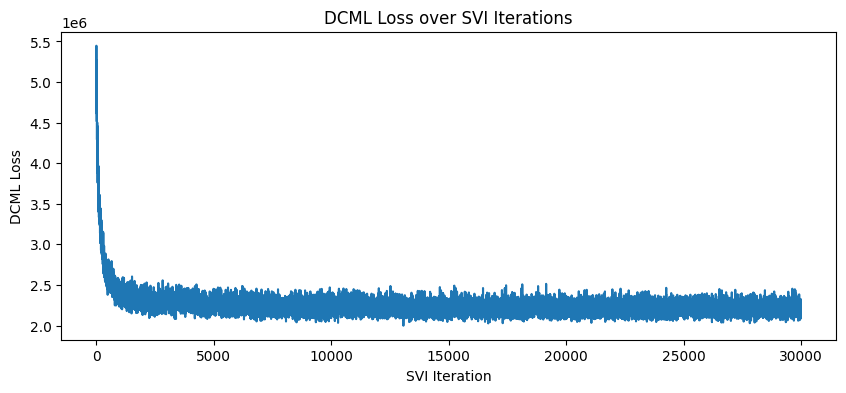

In [20]:
 # run the optimization
max_nharmonies = 14
results = infer_amortized_posteriors_tdp(npcs, max_nharmonies, dcml_obs, nsteps=30000, shuffle_interval=100, save_as="tdpv2")

### **Visualizations**

In [21]:
# plot the histories the parameters to check convergence
# plot_histories("DCML", results['param_history'], results['root_history'])

<ipython-input-17-a39e91f33024>:75: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


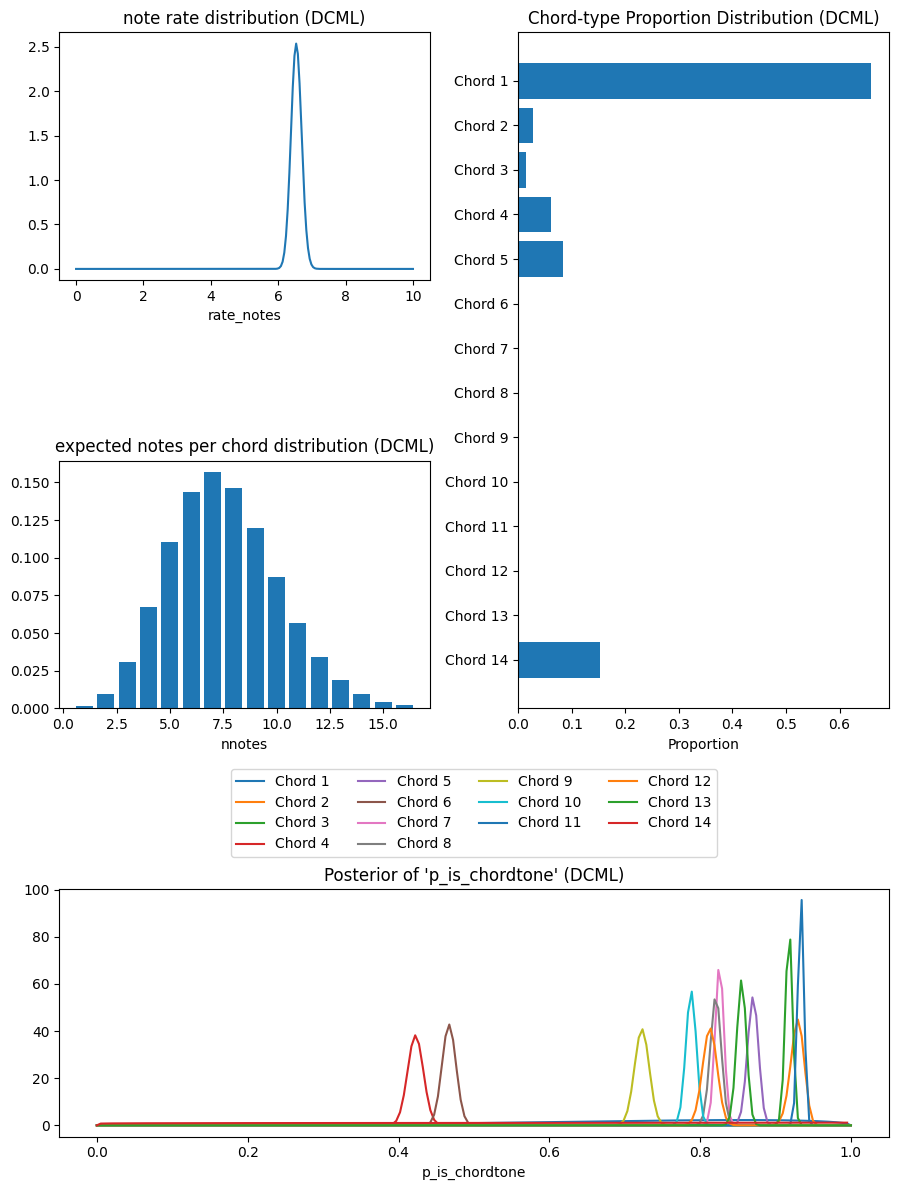

In [22]:
plot_posteriors("DCML", results['params'])

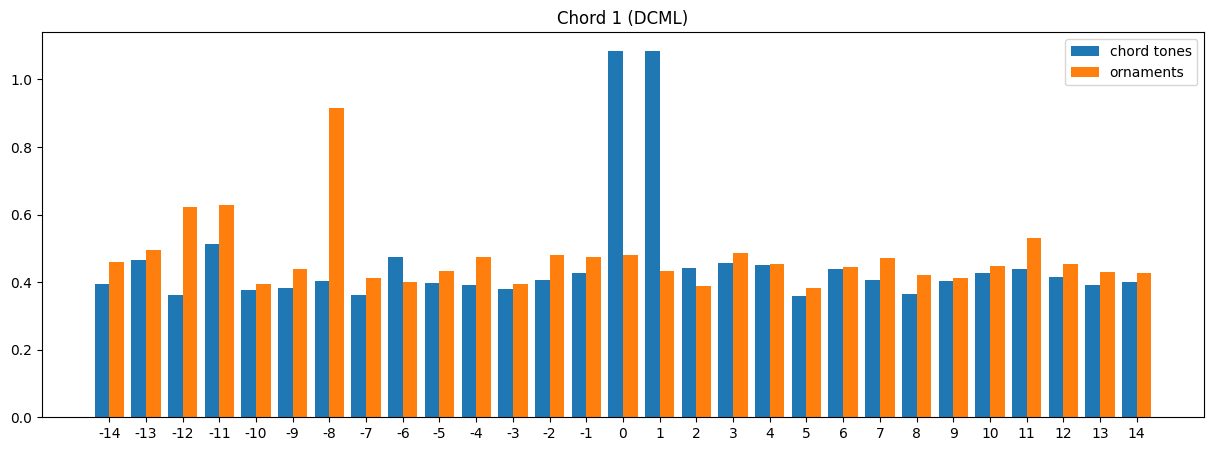

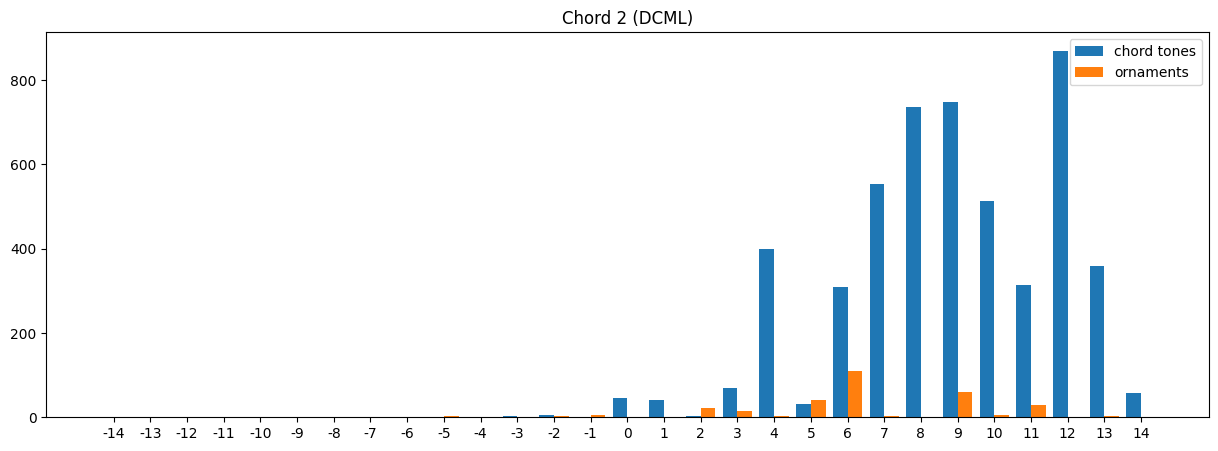

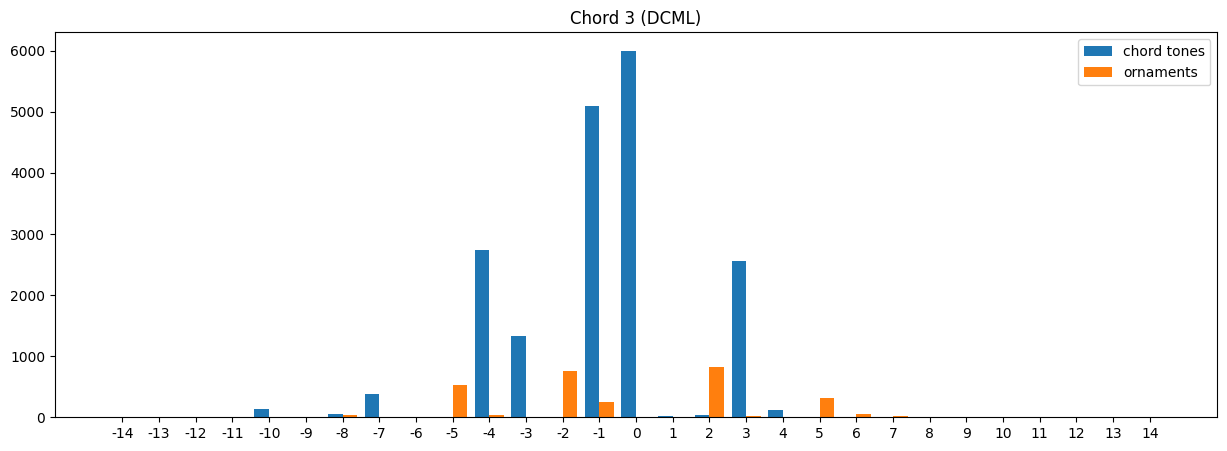

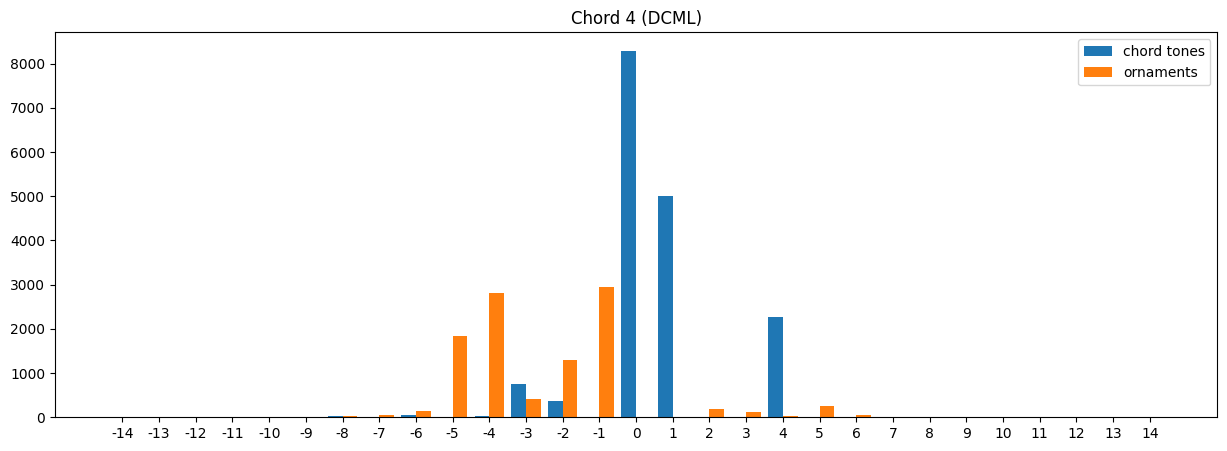

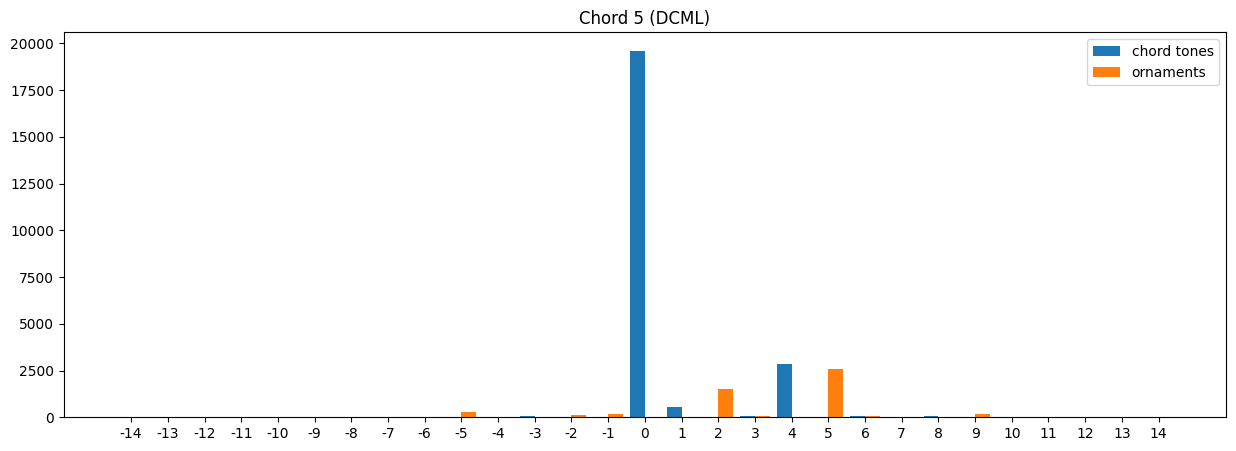

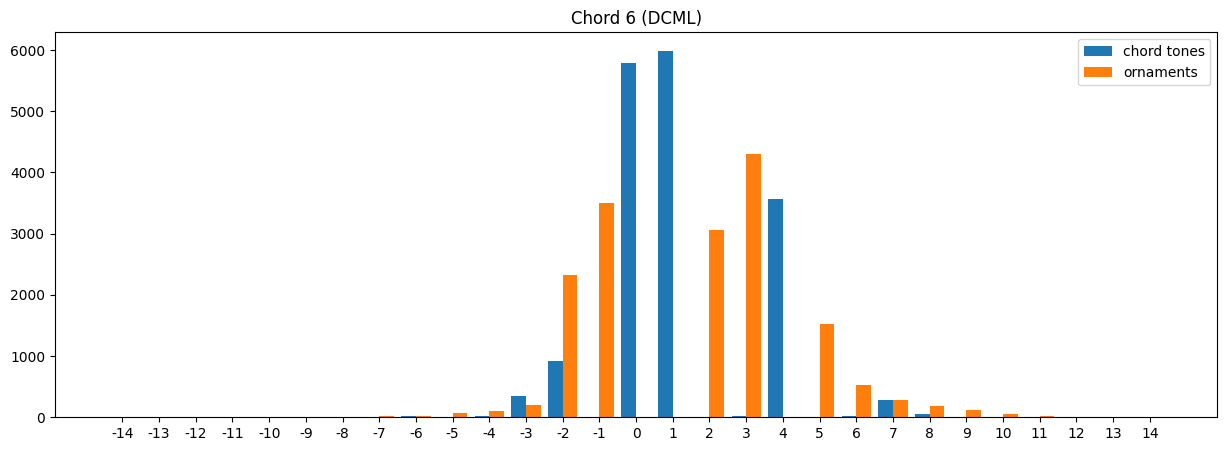

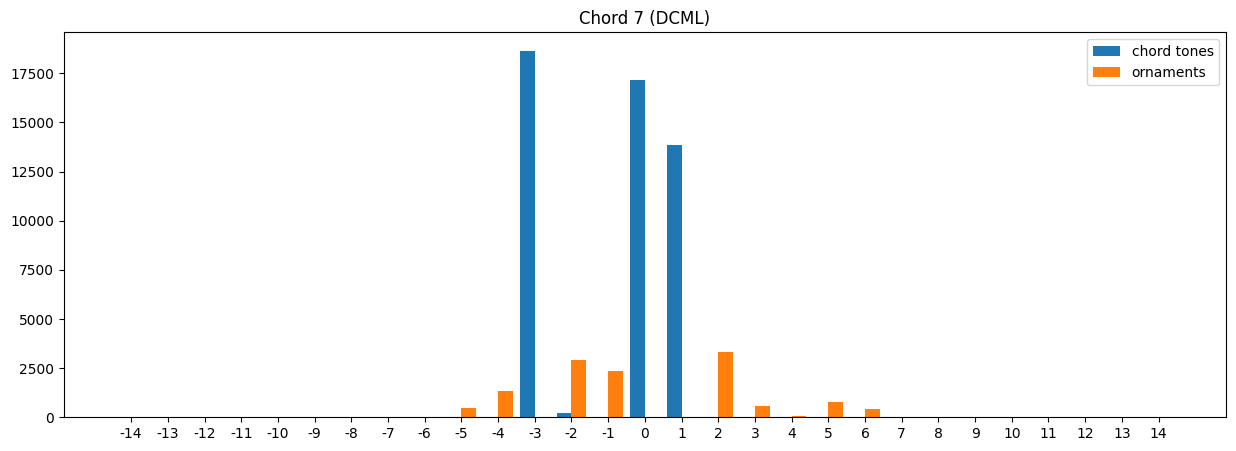

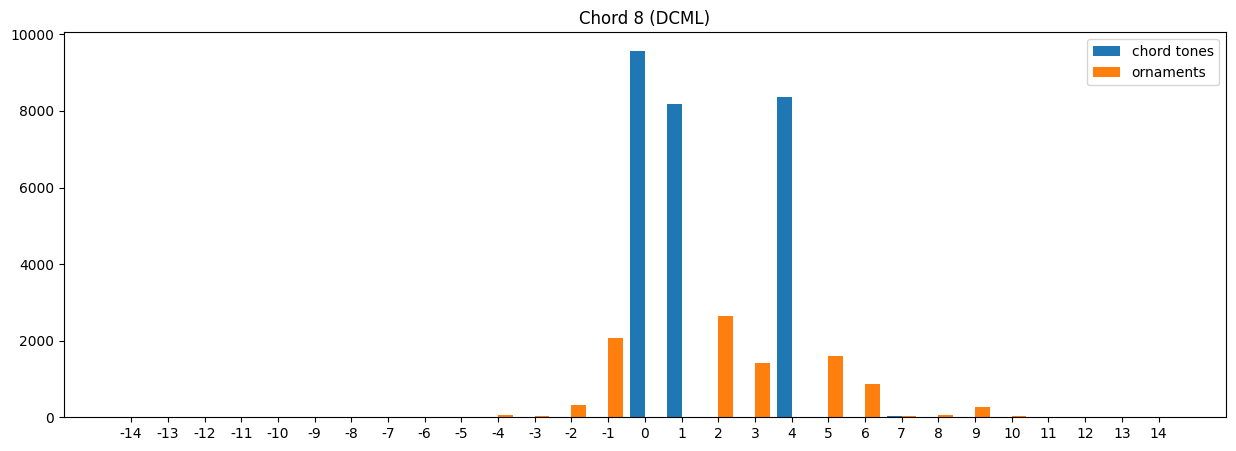

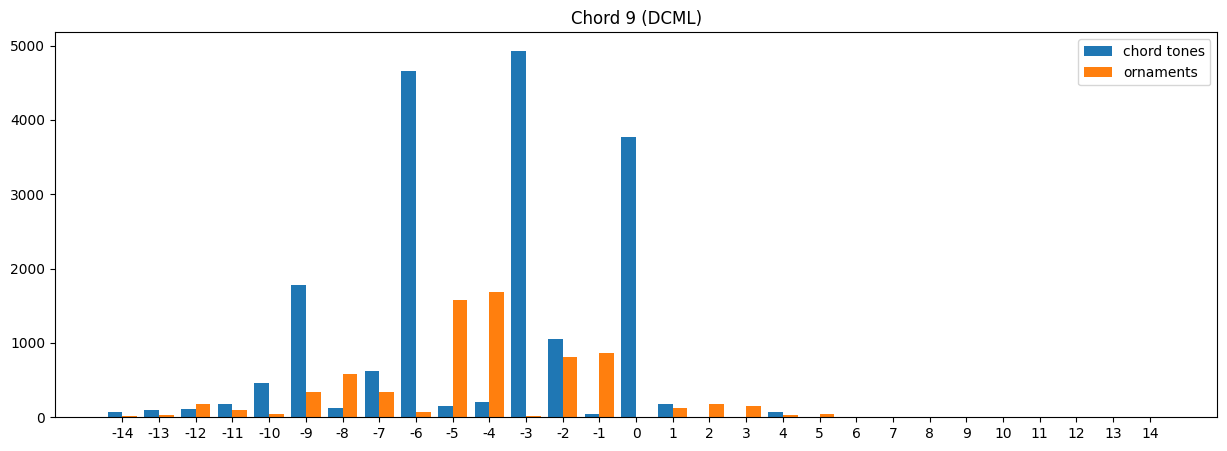

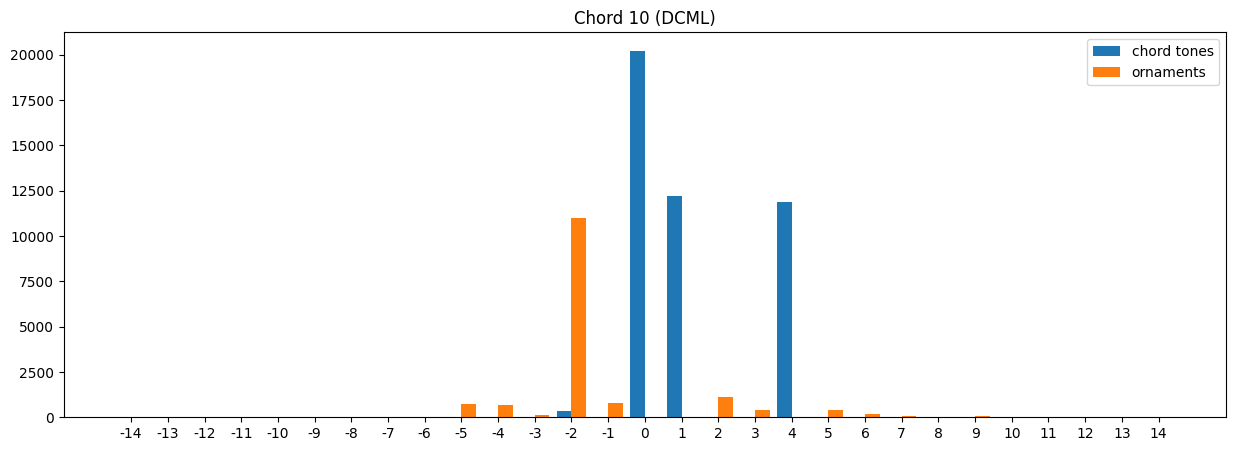

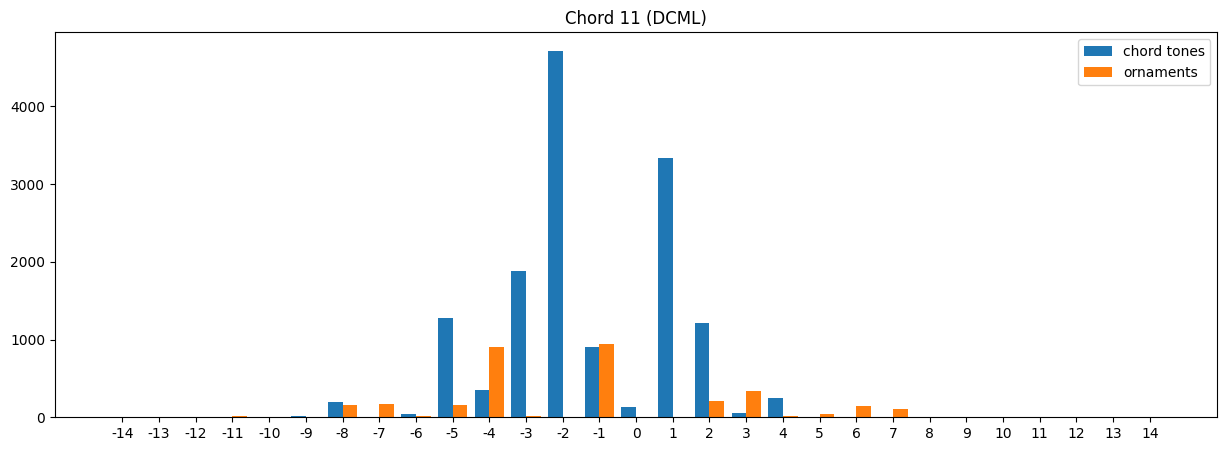

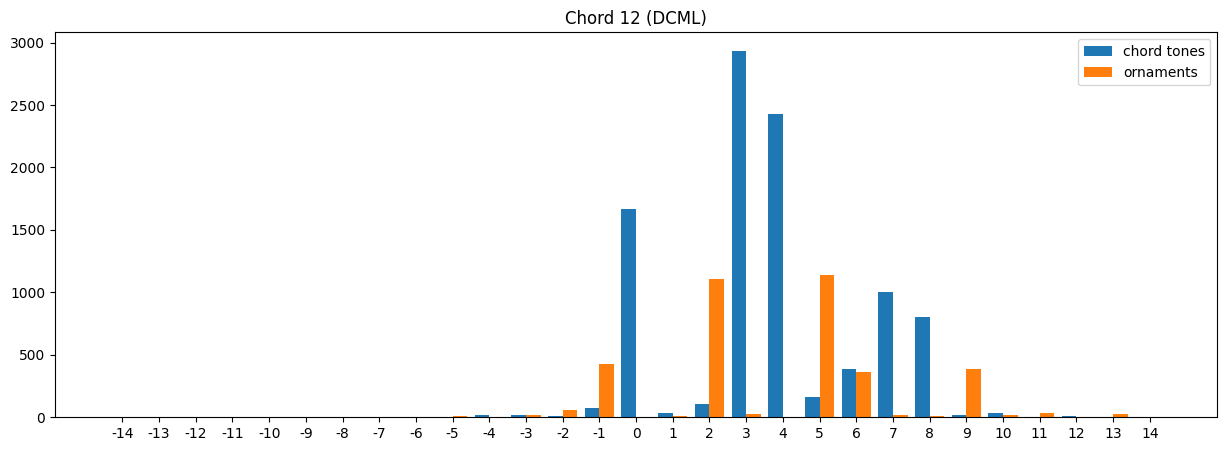

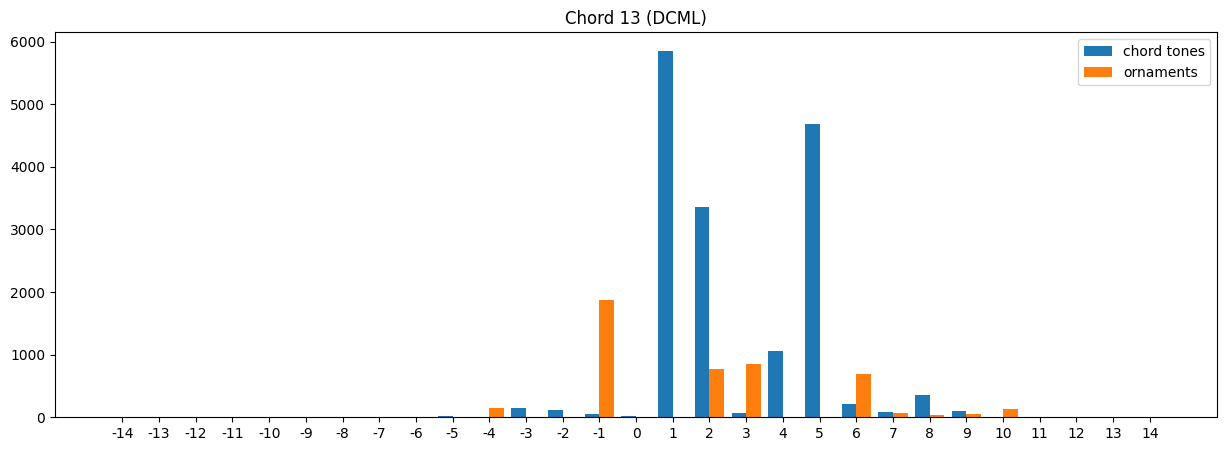

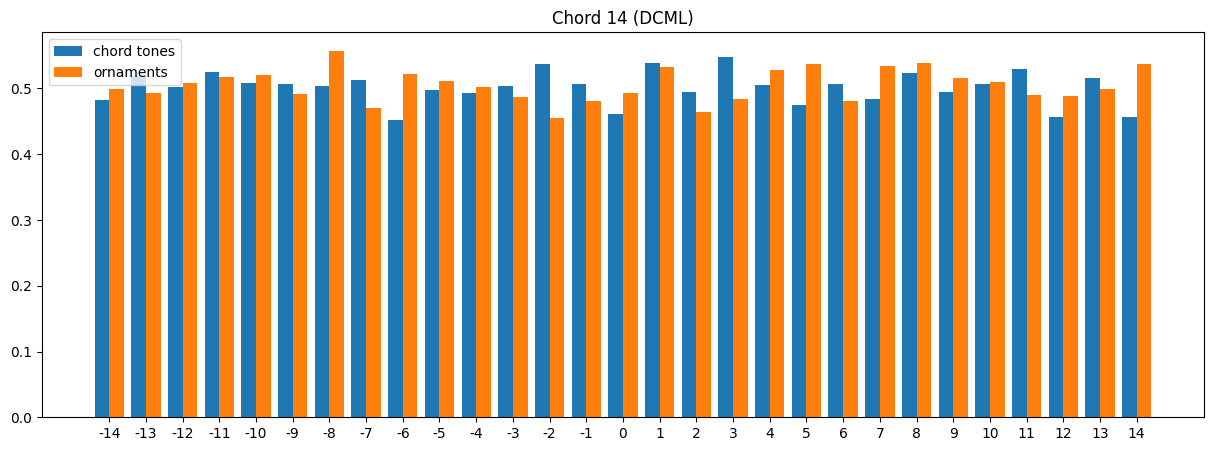

In [23]:
plot_chords("DCML", results['params'])

### **Pruning**

In [24]:
def prune_chord_types(params, threshold=0.99):
    alpha_beta = torch.as_tensor(params['alpha_beta'], dtype=torch.float32)
    beta_beta = torch.as_tensor(params['beta_beta'], dtype=torch.float32)
    expected_beta = alpha_beta / (alpha_beta + beta_beta)
    log_weights = log_stick_breaking(expected_beta)
    weights = torch.exp(log_weights)
    cumulative_weights = torch.cumsum(weights, dim=0)
    significant_indices = (cumulative_weights <= threshold).nonzero(as_tuple=True)[0]

    if significant_indices.numel() == 0:
        pruned_weights = weights
        print("All weights are significant; none pruned.")
    else:
        pruned_weights = weights[:significant_indices[-1] + 1]
        pruned_weights /= torch.sum(pruned_weights)

    print("Number of significant chord types:", len(pruned_weights))
    print("Pruned Weights:", pruned_weights)

    return pruned_weights

prune_chord_types(results['params'], threshold=0.99)

Number of significant chord types: 13
Pruned Weights: tensor([7.7791e-01, 3.3494e-02, 1.6807e-02, 7.2925e-02, 9.8774e-02, 7.2187e-05,
        5.2367e-06, 2.2525e-07, 5.9866e-09, 3.1223e-06, 2.1088e-07, 2.1309e-07,
        7.9425e-06], dtype=torch.float32)


tensor([7.7791e-01, 3.3494e-02, 1.6807e-02, 7.2925e-02, 9.8774e-02, 7.2187e-05,
        5.2367e-06, 2.2525e-07, 5.9866e-09, 3.1223e-06, 2.1088e-07, 2.1309e-07,
        7.9425e-06], dtype=torch.float32)